In [61]:
%matplotlib inline

import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import fiona
import timeit

fiona.Env();

# Change the plot size since it's small with the inital plot
plt.rcParams['figure.figsize'] = (15,12)

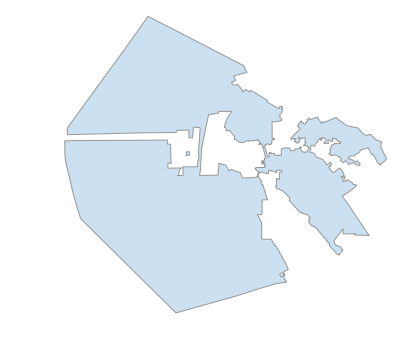

In [3]:
# Going to try using OSMnx to get city boundaries but have file in data dir if needed
richmond = ox.gdf_from_place('Richmond, California')
ox.plot_shape(ox.project_gdf(richmond));

In [4]:
# Check the CRS of the Richmond layer
richmond.crs

{'init': 'epsg:4326'}

In [5]:
# Read in our other data layers.  Parcel layer may give us some issues since it's quite large
bus_stops = gpd.read_file('./data/richmondBusStopsWGS84.geojson')
parcels = gpd.read_file('./data/Interim_Zoning_Delivery/Interim_Zoning_Delivery.shp')

In [6]:
# Check the crs of our bus stop and parcel files
print('Bus Stops: ' + str(bus_stops.crs) + '\nParcels: ' + str(parcels.crs))

Bus Stops: {'init': 'epsg:4326'}
Parcels: {'init': 'epsg:2227'}


In [7]:
# Since we're looking for bus stops within a certain distance of parcels, project all of our layers in an equidistant conic projection
richmond_equi = richmond.to_crs('+proj=eqdc +lat_0=36.5 +lat_1=38.43 +lat_2=37.07 +lon_0=-120.5  +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
bus_stops_equi = bus_stops.to_crs('+proj=eqdc +lat_0=36.5 +lat_1=38.43 +lat_2=37.07 +lon_0=-120.5  +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
parcels_equi = parcels.to_crs('+proj=eqdc +lat_0=36.5 +lat_1=38.43 +lat_2=37.07 +lon_0=-120.5  +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

In [8]:
# Check crs just to make sure things converted
print('Richmond: ' + str(richmond_equi.crs) + '\nBus Stops: ' + str(bus_stops_equi.crs) + '\nParcels: ' + str(parcels_equi.crs))

Richmond: +proj=eqdc +lat_0=36.5 +lat_1=38.43 +lat_2=37.07 +lon_0=-120.5  +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs
Bus Stops: +proj=eqdc +lat_0=36.5 +lat_1=38.43 +lat_2=37.07 +lon_0=-120.5  +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs
Parcels: +proj=eqdc +lat_0=36.5 +lat_1=38.43 +lat_2=37.07 +lon_0=-120.5  +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs


In [9]:
# Maybe export these out and to be read back in 
richmond_equi.to_file('./data/richmond_eqdc/')
bus_stops_equi.to_file('./data/bus_stops_eqdc/')
parcels_equi.to_file('./data/parcels_eqdc/')

/home/mjb/anaconda3/envs/module-07/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [10]:
# Read newly created files back in
richmond_eqdc = gpd.read_file('./data/richmond_eqdc/richmond_eqdc.shp')
bus_stops_eqdc = gpd.read_file('./data/bus_stops_eqdc/bus_stops_eqdc.shp')
parcels_eqdc = gpd.read_file('./data/parcels_eqdc/parcels_eqdc.shp')

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 11 µs


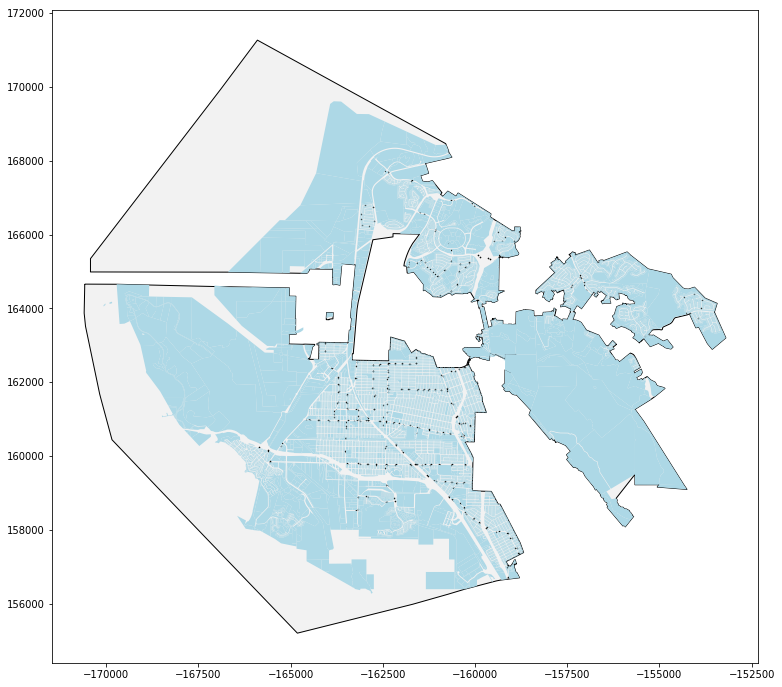

In [17]:
# See how an initial plot works out
# Time it for giggles since there are a crap-ton of parcels
fig, ax = plt.subplots()

richmond_eqdc.plot(ax=ax, edgecolor='black', color='#f2f2f2', zorder=0);
bus_stops_eqdc.plot(ax=ax, edgecolor='black', color='green', markersize=.4, zorder=1);
%time
parcels_eqdc.plot(ax=ax, color='#ADD8E6', zorder=2);

In [39]:
parcels_eqdc.head()

,GIS_Area,Shape_area,Shape_len,INT_ZONES,geometry
0,5685.0,5685.167533,320.526283,RL Single Family Low Density Residential,POLYGON ((-159315.6774157196 157916.0912098948...
1,5045.0,5045.345588,301.854733,RL Single Family Low Density Residential,POLYGON ((-159603.8230093508 157912.8628605674...
2,24635.0,24634.797533,694.070293,RL Single Family Low Density Residential,POLYGON ((-159168.7653157922 157920.9735593386...
3,4221.0,4220.983921,268.448618,RL Single Family Low Density Residential,POLYGON ((-162460.8698140045 157925.6098761225...
4,2985.0,2985.205968,269.675697,RL Single Family Low Density Residential,"POLYGON ((-159293.692202925 157911.051920453, ..."


In [43]:
# Going to work with parcel data and pull out residential parcels >5k ft2
# Change headers to lowercase by adding them to a list 
# Convert headers in df1 to a list to work with them
col_names_parcels_eqdc = list(parcels_eqdc.columns)
print(col_names_parcels_eqdc)

# Iterate over the list and change to lowercase
#  Make the header lower case with list comprehension
col_names_parcels_eqdc = [i.lower() for i in col_names_parcels_eqdc]
print(col_names_parcels_eqdc)

# Assign columns back to the DataFrame
parcels_eqdc.columns = col_names_parcels_eqdc
print(parcels_eqdc.columns)

['GIS_Area', 'Shape_area', 'Shape_len', 'INT_ZONES', 'geometry']
['gis_area', 'shape_area', 'shape_len', 'int_zones', 'geometry']
Index(['gis_area', 'shape_area', 'shape_len', 'int_zones', 'geometry'], dtype='object')


In [48]:
# Check how many rows we have in our parcel data
print(parcels_eqdc.info())

# Grab any parcel over 5k ft2 and check the row count
parcels_eqdc_over5k = parcels_eqdc[parcels_eqdc['gis_area'] >= 5000]
print(parcels_eqdc_over5k.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31239 entries, 0 to 31238
Data columns (total 5 columns):
gis_area      31239 non-null float64
shape_area    31239 non-null float64
shape_len     31239 non-null float64
int_zones     31237 non-null object
geometry      31239 non-null object
dtypes: float64(3), object(2)
memory usage: 1.2+ MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15337 entries, 0 to 31238
Data columns (total 5 columns):
gis_area      15337 non-null float64
shape_area    15337 non-null float64
shape_len     15337 non-null float64
int_zones     15335 non-null object
geometry      15337 non-null object
dtypes: float64(3), object(2)
memory usage: 718.9+ KB
None


In [53]:
# 15k versus 31k so seems to have worked. Now only grab residential parcels
parcels_eqdc_over5k.int_zones.unique()

# Select residential parcels based on unique values from above
# Multple values need to be in an iterable list if using isin()
parcels_eqdc_resi_over5k = parcels_eqdc_over5k.loc[parcels_eqdc_over5k['int_zones'].isin(['RL Single Family Low Density Residential','RM Multi Family Residential','RH Single Family Hillside Residential'])]

In [56]:
# Check number of rows and what the values for our int_zones are to make sure we only got the ones we were looking for. 
print(parcels_eqdc_resi_over5k.info())
print(parcels_eqdc_resi_over5k.int_zones.unique())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 12696 entries, 0 to 31230
Data columns (total 5 columns):
gis_area      12696 non-null float64
shape_area    12696 non-null float64
shape_len     12696 non-null float64
int_zones     12696 non-null object
geometry      12696 non-null object
dtypes: float64(3), object(2)
memory usage: 595.1+ KB
None
['RL Single Family Low Density Residential' 'RM Multi Family Residential'
 'RH Single Family Hillside Residential']


In [59]:
# Check the crs before exporting to a shape file
parcels_eqdc_resi_over5k.crs

{'proj': 'eqdc',
 'lat_0': 36.5,
 'lon_0': -120.5,
 'lat_1': 38.43,
 'lat_2': 37.07,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

In [60]:
# Export to a shape file and then read back in
parcels_eqdc_resi_over5k.to_file('./data/parcels_eqdc_resi_over5k/')
parcels_eqdc_resi_over5k = gpd.read_file('./data/parcels_eqdc_resi_over5k/parcels_eqdc_resi_over5k.shp')


/home/mjb/anaconda3/envs/module-07/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


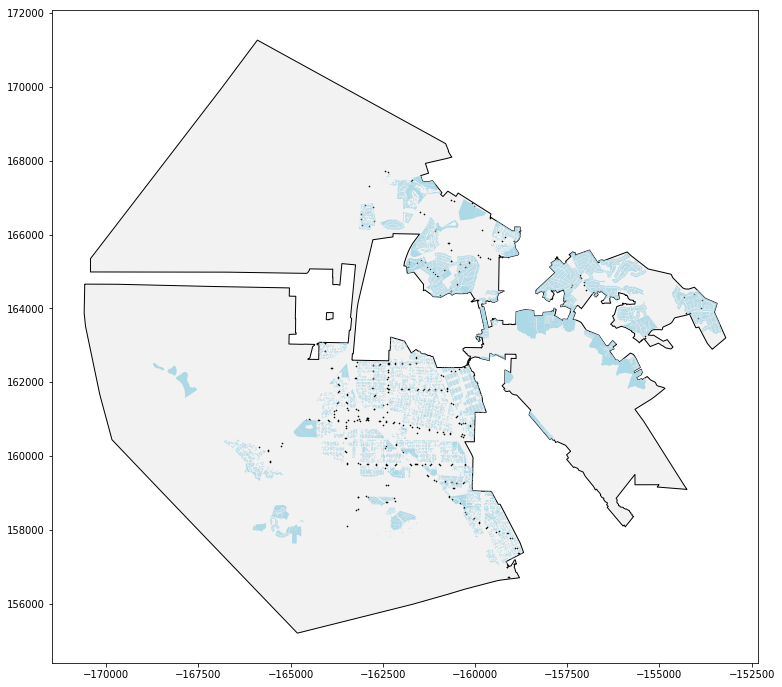

In [62]:
# Plot this new residential parcel data with our previous data
fig, ax = plt.subplots()

richmond_eqdc.plot(ax=ax, edgecolor='black', color='#f2f2f2', zorder=0);
bus_stops_eqdc.plot(ax=ax, edgecolor='black', color='green', markersize=.4, zorder=1);
parcels_eqdc_resi_over5k.plot(ax=ax, color='#ADD8E6', zorder=2);


In [65]:
# Oof, think I can move onto the buffering now.
# Create a buffer column of 402 meters (1/4 mile) in our bus layer
bus_stops_eqdc['buffer'] = bus_stops_eqdc.buffer(402)
# note they are now polygons in meters
bus_stops_eqdc.head()

,stp_identi,stp_511_id,stp_descri,route,geometry,buffer
0,1600620,53275.0,Mc Bryde Av:Amador St,684,(POINT (-160437.3566015214 162368.3485793834)),POLYGON ((-160035.3566015214 162368.3485793834...
1,1600630,53657.0,Mc Bryde Av:Marin Av,684,(POINT (-160193.971663522 162552.2211818504)),"POLYGON ((-159791.971663522 162552.2211818504,..."
2,1600640,53763.0,Mc Bryde Av:Yuba Av,684,(POINT (-160303.5222122292 162415.6961755479)),POLYGON ((-159901.5222122292 162415.6961755479...
3,9900600,57736.0,El Portal Dr:Barranca St,L 74,(POINT (-159938.9375243707 164221.166629322)),"POLYGON ((-159536.9375243707 164221.166629322,..."
4,9900850,52159.0,Mc Bryde Av:Ralston Av,684,(POINT (-160186.5925223861 162502.3420075534)),POLYGON ((-159784.5925223861 162502.3420075534...


In [68]:
# Make the 'buffer' column the active geometry column instead of 'geometry'
bus_stops_eqdc = bus_stops_eqdc.set_geometry('buffer')
bus_stops_eqdc.geometry.name

'buffer'

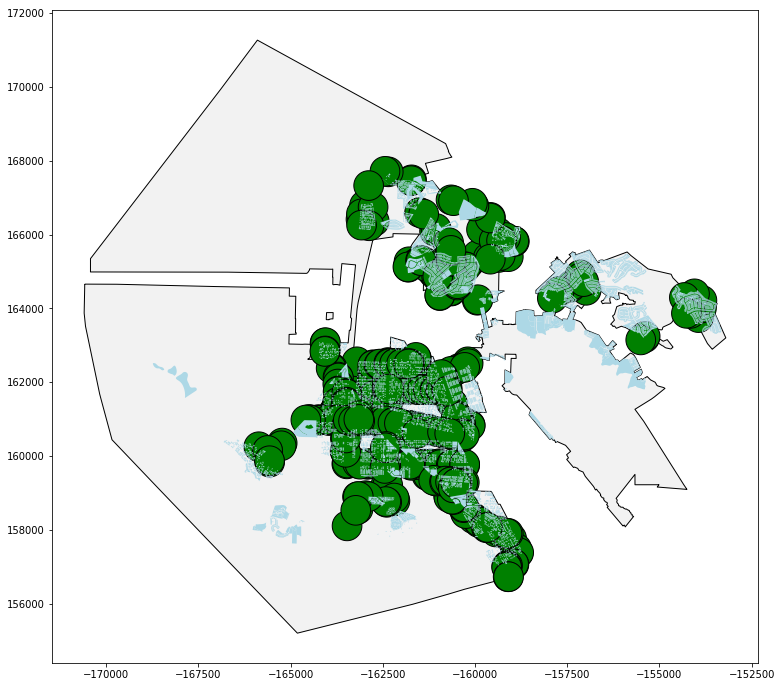

In [69]:
# Plot one more time but with buffers now
fig, ax = plt.subplots()

richmond_eqdc.plot(ax=ax, edgecolor='black', color='#f2f2f2', zorder=0);
bus_stops_eqdc.plot(ax=ax, edgecolor='black', color='green', markersize=.4, zorder=1);
parcels_eqdc_resi_over5k.plot(ax=ax, color='#ADD8E6', zorder=2);


In [70]:
# Create a single polygon of our parcels which we can use to clip
%time
parcel_poly = parcels_eqdc_resi_over5k.geometry.unary_union

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.6 µs


In [74]:
# Create layer for intersection of bus stops with parcel poly
%time
bus_stops_eqdc_near_parcels = bus_stops_eqdc[bus_stops_eqdc.geometry.intersects(parcel_poly)]

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.1 µs


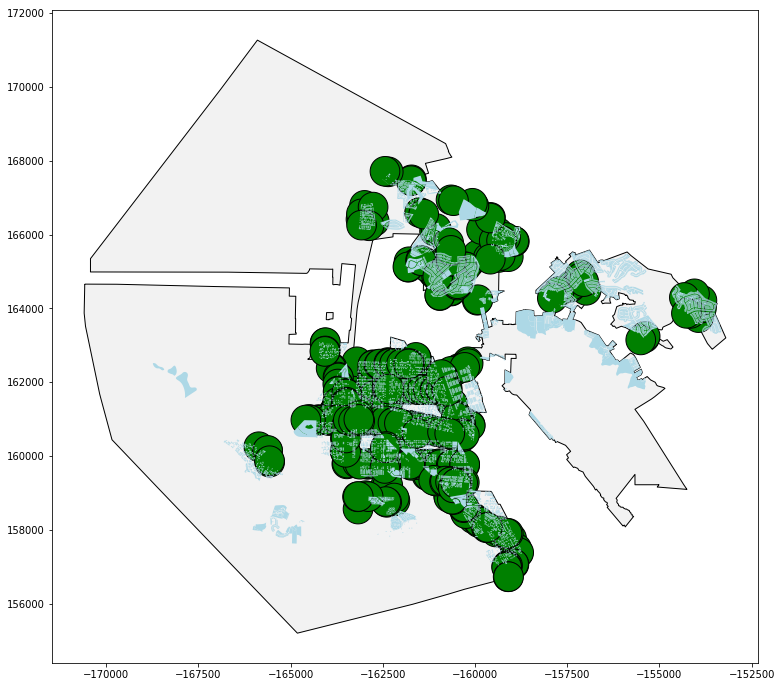

In [76]:
# Plot this new data
fig, ax = plt.subplots()

richmond_eqdc.plot(ax=ax, edgecolor='black', color='#f2f2f2', zorder=0);
bus_stops_eqdc_near_parcels.plot(ax=ax, edgecolor='black', color='green', markersize=.4, zorder=1);
parcels_eqdc_resi_over5k.plot(ax=ax, color='#ADD8E6', zorder=2);

In [77]:
# Think I flipped this and actually should have mad a poly of my buffers to see where parcels intesect
bus_poly = bus_stops_eqdc.geometry.unary_union

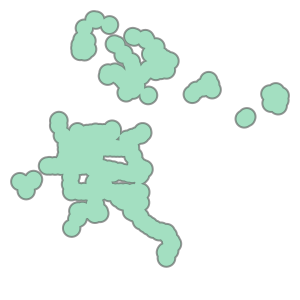

In [79]:
bus_poly

In [80]:
# Residential parcels over 5k ft2 that intersect parcels
%time
parcels_eqdc_resi_over5k_near_bus = parcels_eqdc_resi_over5k[parcels_eqdc_resi_over5k.geometry.intersects(bus_poly)]

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 18.6 µs


In [83]:
# Hopefully less than 12696 since obvious some parcels don't fall within the buffer
parcels_eqdc_resi_over5k_near_bus.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9708 entries, 0 to 12682
Data columns (total 5 columns):
gis_area      9708 non-null float64
shape_area    9708 non-null float64
shape_len     9708 non-null float64
int_zones     9708 non-null object
geometry      9708 non-null object
dtypes: float64(3), object(2)
memory usage: 455.1+ KB


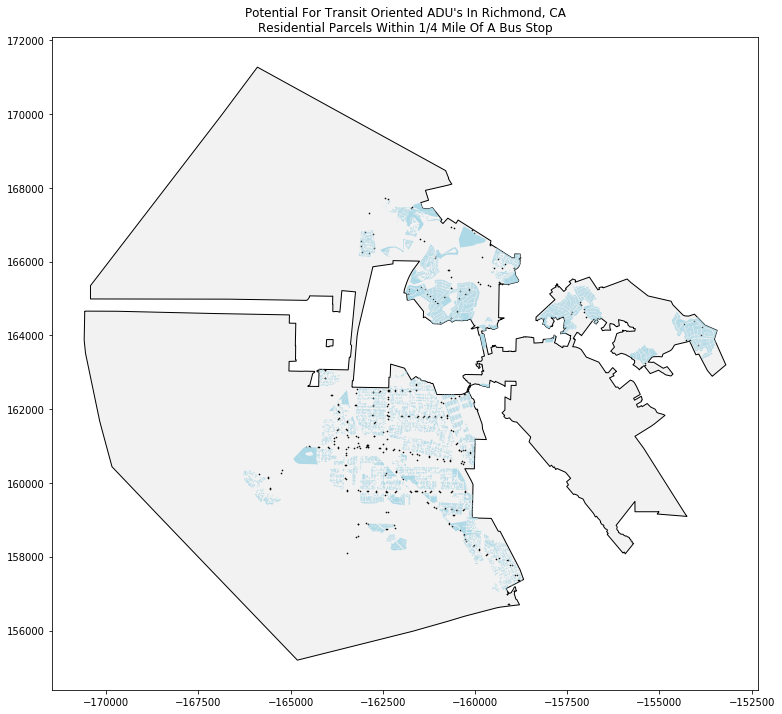

In [91]:
# Return bus_stop geometry to the 'geometry' column since we don't need to plot the buffers
bus_stops_eqdc = bus_stops_eqdc.set_geometry('geometry')

# Plot this new data
fig, ax = plt.subplots()

title = "Potential For Transit Oriented ADU's In Richmond, CA" + "\n" + "Residential Parcels Within 1/4 Mile Of A Bus Stop"
ax.set(title=title)


richmond_eqdc.plot(ax=ax, edgecolor='black', color='#f2f2f2', zorder=0);
bus_stops_eqdc.plot(ax=ax, edgecolor='black', color='green', markersize=.4, zorder=1);
parcels_eqdc_resi_over5k_near_bus.plot(ax=ax, color='#ADD8E6', zorder=2);